In [ ]:
import pm4py
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.util import constants
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator


# ===============================================
# Configuration 
# ===============================================

# Data Loading
log_path = "BPI Challenge 2017.xes"
try:
    log = pm4py.read_xes(log_path) 
    print("Log loaded successfully from the subfolder!")
except Exception as e:
    print(f"Error loading log: {e}")
    print("Check if the subfolder name and file name are spelled correctly.")

# Convert the PM4Py log object to a Pandas DataFrame for easier manipulation
df_raw = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
print(f"Original log loaded: {df_raw.shape[0]} events, {df_raw['case:concept:name'].nunique()} cases")

# ===============================================
# BASIC ANALYSIS (ON RAW DATA)
# ===============================================
print("\n--- Basic Analysis (Raw Log) ---")

# 1. Number of cases
num_cases_raw = df_raw['case:concept:name'].nunique()
print(f"Number of Cases: {num_cases_raw}")

# 2. Number of events
num_events_raw = len(df_raw)
print(f"Number of Events: {num_events_raw}")

# 3. Number of process variants
variants_raw = pm4py.get_variants_as_tuples(log)
num_variants_raw = len(variants_raw)
print(f"Number of Process Variants: {num_variants_raw}")

# 4. Number of case and event labels
# Event labels (Activities)
event_labels_raw = df_raw['concept:name'].nunique()
print(f"Number of Event Labels (Activities): {event_labels_raw}")
# Case labels
case_attributes = [col for col in df_raw.columns if col.startswith('case:') and col != 'case:concept:name']
print(f"Number of Case Attributes (Labels): {len(case_attributes)}")


# 5. Case length (number of events per case)
case_sizes_raw = df_raw.groupby('case:concept:name').size()
mean_case_length = case_sizes_raw.mean()
std_case_length = case_sizes_raw.std()
print(f"Case Length (events): Mean = {mean_case_length:.2f}, Std Dev = {std_case_length:.2f}")

# 6. Case duration
df_raw_sorted = df_raw.sort_values(['case:concept:name', 'time:timestamp'])
case_durations_raw = df_raw_sorted.groupby('case:concept:name')['time:timestamp'].apply(
    lambda x: x.max() - x.min()
)
mean_case_duration = case_durations_raw.mean()
std_case_duration = case_durations_raw.std()
print(f"Case Duration: Mean = {mean_case_duration}, Std Dev = {std_case_duration}")

# 7. Number of categorical event attributes
event_attributes = [col for col in df_raw.columns if not col.startswith('case:') and col not in ['time:timestamp', 'concept:name']]
print(f"Number of other event attributes: {len(event_attributes)}")


c:\Users\ASUS\anaconda3\envs\bppm_course\lib\site-packages\pm4py\utils.py:987: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


Log loaded successfully from the subfolder!
Original log loaded: 1202267 events, 31509 cases


,org:resource,case:LoanGoal,CreditScore,Selected,concept:name,NumberOfTerms,time:timestamp,lifecycle:transition,Accepted,OfferID,case:ApplicationType,case:RequestedAmount,MonthlyCost,OfferedAmount,EventOrigin,case:concept:name,FirstWithdrawalAmount,Action,EventID
0,User_1,Existing loan takeover,NaN,None,A_Create Application,NaN,2016-01-01 09:51:15.304000+00:00,complete,None,None,New credit,20000.0,NaN,NaN,Application,Application_652823628,NaN,Created,Application_652823628
1,User_1,Existing loan takeover,NaN,None,A_Submitted,NaN,2016-01-01 09:51:15.352000+00:00,complete,None,None,New credit,20000.0,NaN,NaN,Application,Application_652823628,NaN,statechange,ApplState_1582051990
2,User_1,Existing loan takeover,NaN,None,W_Handle leads,NaN,2016-01-01 09:51:15.774000+00:00,schedule,None,None,New credit,20000.0,NaN,NaN,Workflow,Application_652823628,NaN,Created,Workitem_1298499574
3,User_1,Existing loan takeover,NaN,None,W_Handle leads,NaN,2016-01-01 09:52:36.392000+00:00,withdraw,None,None,New credit,20000.0,NaN,NaN,Workflow,Application_652823628,NaN,Deleted,Workitem_1673366067
4,User_1,Existing loan takeover,NaN,None,W_Complete application,NaN,2016-01-01 09:52:36.403000+00:00,schedule,None,None,New credit,20000.0,NaN,NaN,Workflow,Application_652823628,NaN,Created,Workitem_1493664571



--- Basic Analysis (Raw Log) ---
Number of Cases: 31509
Number of Events: 1202267
Number of Process Variants: 15930
Number of Event Labels (Activities): 26
Number of Case Attributes (Labels): 3
Case Length (events): Mean = 38.16, Std Dev = 16.72
Case Duration: Mean = 21 days 21:35:25.923069948, Std Dev = 13 days 04:03:41.690875763
Number of other event attributes: 13


In [6]:
# ===============================================
# DATA CLEANING
# ===============================================
print("\n--- Starting Data Cleaning ---")
df_cleaned = df_raw.copy() 

# --- Sort events inside each case ---
df_cleaned = df_cleaned.sort_values(['case:concept:name', 'time:timestamp'])

# --- Remove events with missing timestamps ---
initial_shape = df_cleaned.shape
df_cleaned = df_cleaned.dropna(subset=['time:timestamp'])
print(f"Timestamp cleaning removed: {initial_shape[0] - df_cleaned.shape[0]} events")

# --- Remove cases with only 1 event (incomplete traces) ---
case_sizes = df_cleaned.groupby('case:concept:name').size()
valid_cases = case_sizes[case_sizes > 1].index
initial_shape = df_cleaned.shape
df_cleaned = df_cleaned[df_cleaned['case:concept:name'].isin(valid_cases)]
print(f"Incomplete trace removal removed: {initial_shape[0] - df_cleaned.shape[0]} events")

# --- Remove non-complete events ---
initial_shape = df_cleaned.shape
df_cleaned = df_cleaned[df_cleaned["lifecycle:transition"] == "complete"]
print(f"Non-complete event removal removed: {initial_shape[0] - df_cleaned.shape[0]} events")

# --- Remove Duplicate Events (if Case ID, Activity, and Timestamp are identical) ---
unique_cols = ['case:concept:name', 'concept:name', 'time:timestamp'] 
initial_events = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates(subset=unique_cols, keep='first')
print(f"Duplicate removal removed: {initial_events - len(df_cleaned)} events")

# --- Final cleaned DataFrame ---
df_cleaned = df_cleaned.reset_index(drop=True)
log_cleaned = log_converter.apply(df_cleaned)
print(f"\nFinal cleaned DataFrame: {df_cleaned.shape[0]} events, {df_cleaned['case:concept:name'].nunique()} cases, {len(pm4py.get_variants_as_tuples(log_cleaned))} variants")
#display(df_cleaned.head())



--- Starting Data Cleaning ---
Timestamp cleaning removed: 0 events
Incomplete trace removal removed: 0 events
Non-complete event removal removed: 726961 events
Duplicate removal removed: 0 events

Final cleaned DataFrame: 475306 events, 31509 cases, 5623 variants


In [7]:
# ===============================================
# PREPARE LOG FOR DISCOVERY 
# ===============================================
print("\n--- Starting Data Filtering ---")

# --- Filter Infrequent Activities ---
# Removes activities that appear in less than 1% (0.01) of cases.
initial_events = len(df_cleaned)
min_activity_stake = 0.01 
log_filtered_activities = attributes_filter.filter_log_relative_occurrence_event_attribute(
    log_cleaned, 
    min_activity_stake, # Keep activities that are in at least 1% of cases
    parameters={
        constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'concept:name',
        "level": "cases"
    }
)
df_filtered_activities = log_converter.apply(log_filtered_activities, variant=log_converter.Variants.TO_DATA_FRAME)
print(f"Infrequent Activity filtering (<1%) removed: {initial_events - len(df_filtered_activities)} events, we still have {df_filtered_activities['case:concept:name'].nunique()} cases")

# --- Filter End Activities ---
initial_events = len(df_filtered_activities)
valid_ends = [
    'O_Cancelled', 
    'A_Pending', 
    'O_Refused', 
    'A_Cancelled', 
    'A_Complete', 
    'A_Denied'
]
log_optimized = pm4py.filter_end_activities(log_filtered_activities, valid_ends)
df_optimized = log_converter.apply(log_optimized, variant=log_converter.Variants.TO_DATA_FRAME)
print(f"End Activities filtering removed: {initial_events - len(df_optimized)} events, we still have {df_optimized['case:concept:name'].nunique()} cases")

# --- Filter for 80% Variant Coverage ---
initial_events = len(df_optimized)
coverage_percentage = 0.8  
log_filtered = variants_filter.filter_log_variants_percentage(
    log_optimized, 
    coverage_percentage
)
df_final = log_converter.apply(log_filtered, variant=log_converter.Variants.TO_DATA_FRAME)
print(f"Infrequent Process Variants filtering removed: {initial_events - len(df_final)} events, we still have {df_final['case:concept:name'].nunique()} cases")

# --- Final log for discovery ---
log_final_for_discovery = log_converter.apply(df_final)
print(f"\nFinal log for discovery: {df_final.shape[0]} events, {df_final['case:concept:name'].nunique()} cases, {len(pm4py.get_variants_as_tuples(log_final_for_discovery))} variants")



--- Starting Data Filtering ---
Infrequent Activity filtering (<1%) removed: 282 events, we still have 31509 cases
End Activities filtering removed: 78622 events, we still have 26578 cases
Infrequent Process Variants filtering removed: 111974 events, we still have 21438 cases

Final log for discovery: 284428 events, 21438 cases, 445 variants



--- Ready for Process Discovery ---
Displaying Heuristic Miner Model...


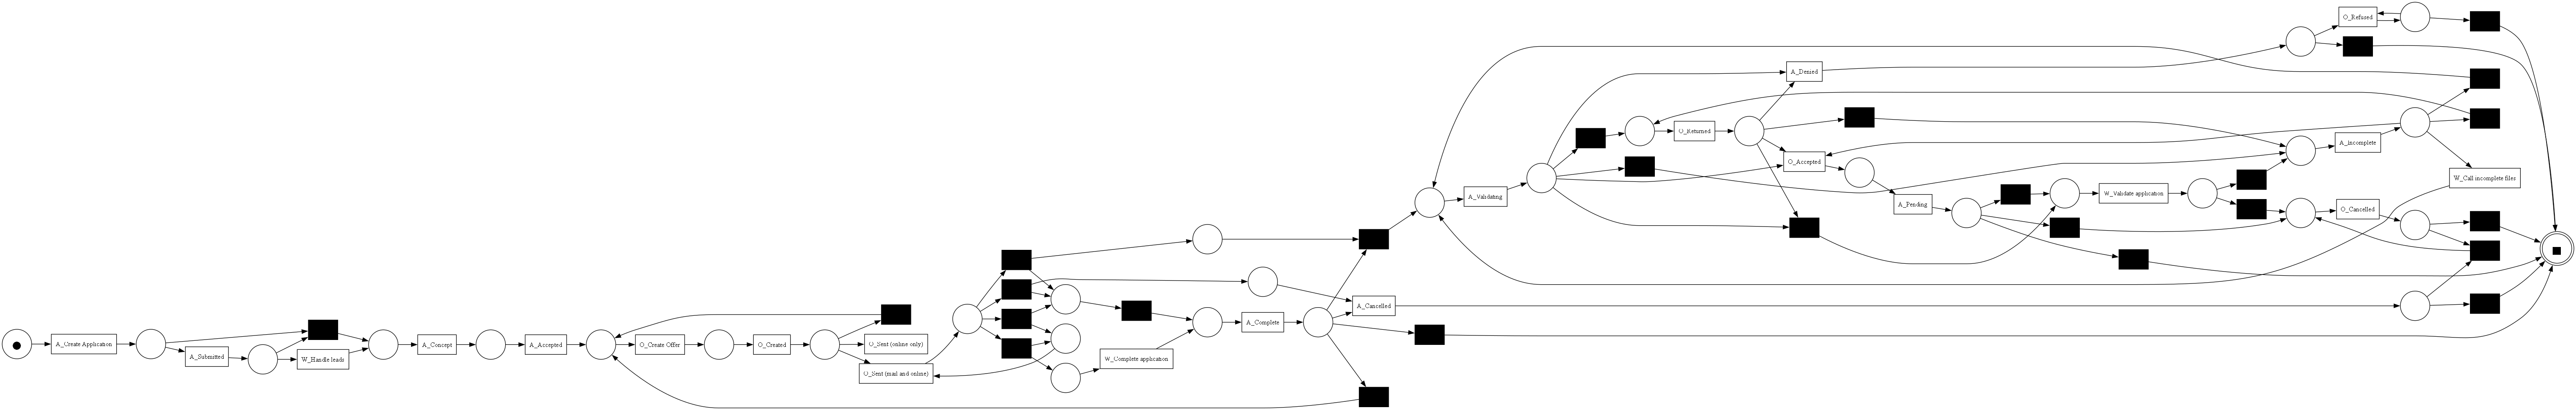

Displaying Inductive Miner Model...


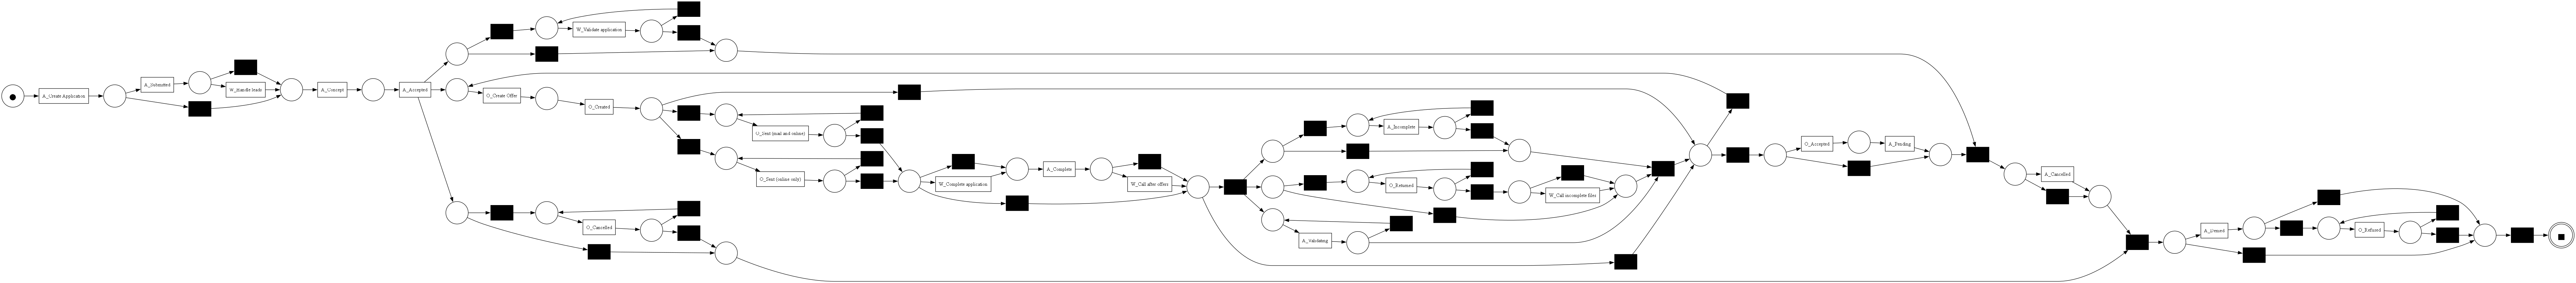

In [8]:
# ===============================================
# PROCESS DISCOVERY & VALIDATION
# ===============================================
print("\n--- Ready for Process Discovery ---")

# --- Discover the Heuristic Net ---
heu_params = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99}
heu_net_tuple = heuristics_miner.apply(log_final_for_discovery, parameters=heu_params)
net_heu, im_heu, fm_heu = heu_net_tuple
print("Displaying Heuristic Miner Model...")
pm4py.view_petri_net(net_heu, im_heu, fm_heu)

# --- Discover the Inductive Net ---
process_tree = inductive_miner.apply(log_final_for_discovery)
net_ind, im_ind, fm_ind = pm4py.convert_to_petri_net(process_tree)
print("Displaying Inductive Miner Model...")
pm4py.view_petri_net(net_ind, im_ind, fm_ind)

In [9]:
# ===============================================
# DEFINING CUSTOM SIMPLICITY METRICS 
# ===============================================

# --- Implementing Metric 6 ---
def custom_metric_simple_structural_appropriateness(net):
    num_places = len(net.places)
    num_transitions = len(net.transitions)

    # Get unique labels (ignore invisible transitions which have label=None)
    unique_labels = set()
    for t in net.transitions:
        if t.label is not None:
            unique_labels.add(t.label)
            
    numerator = len(unique_labels) + 2
    denominator = num_transitions + num_places
    
    if denominator == 0: return 0
    return numerator / denominator

# --- Average number of connections per node ---
def custom_metric_average_node_degree(net):
    num_nodes = len(net.places) + len(net.transitions)
    num_arcs = len(net.arcs)
    
    if num_nodes == 0: return 0
    return num_arcs / num_nodes

# =========================================================
# CALCULATING METRICS FOR HEURISTIC MINER
# =========================================================
print("\n--- Evaluating Heuristic Miner Model ---")

# 1. FITNESS
fitness_heu = pm4py.fitness_token_based_replay(log_final_for_discovery, net_heu, im_heu, fm_heu)
print(f"Heuristic Miner Fitness: {fitness_heu['log_fitness']:.4f}")

# 2. PRECISION
precision_heu = pm4py.precision_token_based_replay(log_final_for_discovery, net_heu, im_heu, fm_heu)
print(f"Heuristic Miner Precision: {precision_heu:.4f}")

# 3. SIMPLICITY
simplicity_heu = simplicity_evaluator.apply(net_heu)
print(f"Heuristic Miner Simplicity: {simplicity_heu:.4f}")

# 4. GENERALIZATION
gen_heu = generalization_evaluator.apply(log_final_for_discovery, net_heu, im_heu, fm_heu)
print(f"Heuristic Miner Generalization: {gen_heu:.4f}")

# 5. CUSTOM SIMPLE STRUCTURAL APPROPRIATNESS
simp_heu_custom1 = custom_metric_simple_structural_appropriateness(net_heu)
print(f"Custom Simple Structural Appropriateness: {simp_heu_custom1:.4f}")

# 6. CUSTOM AVERAGE NODE DEGREE
simp_heu_custom2 = custom_metric_average_node_degree(net_heu)
print(f"Custom Average Node Degree: {simp_heu_custom2:.4f}")


--- Evaluating Heuristic Miner Model ---


replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Heuristic Miner Fitness: 0.8188


replaying log with TBR, completed traces ::   0%|          | 0/1307 [00:00<?, ?it/s]

Heuristic Miner Precision: 0.9664
Heuristic Miner Simplicity: 0.5797


replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Heuristic Miner Generalization: 0.9188
Custom Simple Structural Appropriateness: 0.3000
Custom Average Node Degree: 1.3625


In [10]:
# =========================================================
# CALCULATING METRICS FOR INDUCTIVE MINER
# =========================================================
print("\n--- Evaluating Inductive Miner Model ---")

# 1. FITNESS
fitness_ind = pm4py.fitness_token_based_replay(log_final_for_discovery, net_ind, im_ind, fm_ind)
print(f"Inductive Miner Fitness: {fitness_ind['log_fitness']:.4f}")

# 2. PRECISION
precision_ind = pm4py.precision_token_based_replay(log_final_for_discovery, net_ind, im_ind, fm_ind)
print(f"Inductive Miner Precision: {precision_ind:.4f}")

# 3. SIMPLICITY
simplicity_ind = simplicity_evaluator.apply(net_ind)
print(f"Inductive Miner Simplicity: {simplicity_ind:.4f}")

# 4. GENERALIZATION
gen_ind = generalization_evaluator.apply(log_final_for_discovery, net_ind, im_ind, fm_ind)
print(f"Inductive Miner Generalization: {gen_ind:.4f}")

# 5. CUSTOM SIMPLE STRUCTURAL APPROPRIATNESS
simp_ind_custom1 = custom_metric_simple_structural_appropriateness(net_ind)
print(f"Custom Simple Structural Appropriateness: {simp_ind_custom1:.4f}")

# 6. CUSTOM AVERAGE NODE DEGREE
simp_ind_custom2 = custom_metric_average_node_degree(net_ind)
print(f"Custom Average Node Degree: {simp_ind_custom2:.4f}")



--- Evaluating Inductive Miner Model ---


replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Inductive Miner Fitness: 1.0000


replaying log with TBR, completed traces ::   0%|          | 0/1307 [00:00<?, ?it/s]

Inductive Miner Precision: 0.4258
Inductive Miner Simplicity: 0.6647


replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Inductive Miner Generalization: 0.9583
Custom Simple Structural Appropriateness: 0.2174
Custom Average Node Degree: 1.2522


In [11]:
# --- Finding the top 30 Variants ---

variants = pm4py.get_variants_as_tuples(log_final_for_discovery)
variant_list = [(variant, len(cases)) for variant, cases in variants.items()]
variant_list_sorted = sorted(variant_list, key=lambda x: x[1], reverse=True)
top_30 = variant_list_sorted[:30]
for var, count in top_30:
    print(var, "-->", count)

('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') --> 2209
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Cancelled', 'O_Cancelled') --> 1917
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Cancelled', 'O_Cancelled') --> 1579
('A_Create Application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') --> 969
('A_Create Application', 'A_Submitted', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'A_Complete', 'A_Validating', 'O_Returned', 'O_Accepted', 'A_Pending') --> 678
('A_C


--- Evaluating the Signavio Model ---
Manual BPMN model loaded successfully.


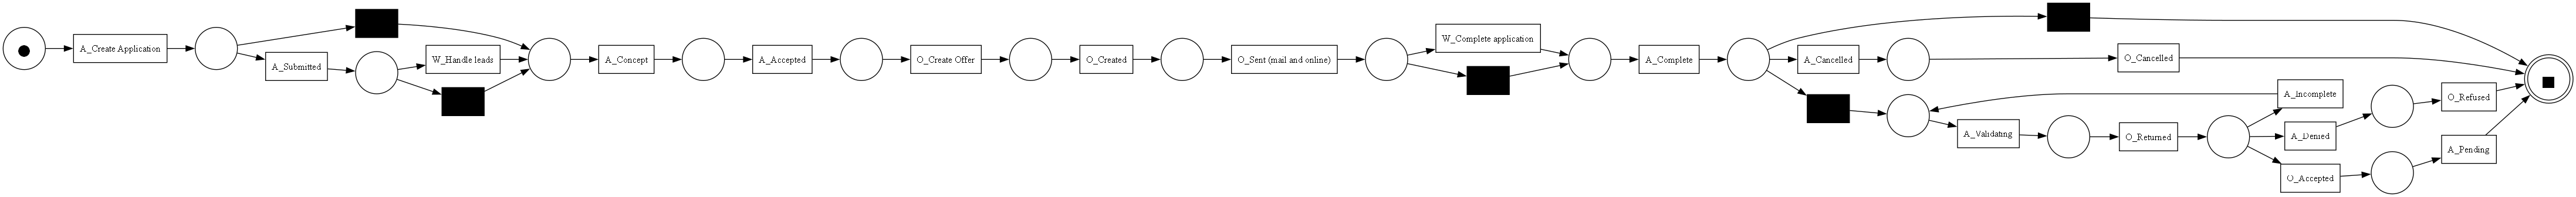

replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Signavio Model Fitness: 0.9454


replaying log with TBR, completed traces ::   0%|          | 0/1307 [00:00<?, ?it/s]

Signavio Model Precision: 0.9764
Signavio Model Simplicity (Arc Degree): 0.7778


replaying log with TBR, completed traces ::   0%|          | 0/445 [00:00<?, ?it/s]

Signavio Model Generalization: 0.9818


In [12]:
# ===============================================
# EVALUATING MANUAL SIGNAVIO MODEL
# ===============================================
print("\n--- Evaluating the Signavio Model ---")

# 1. Load the BPMN file
try:
    # Make sure the filename matches exactly
    bpmn_manual = pm4py.read_bpmn("Signavio Model.bpmn")
    print("Manual BPMN model loaded successfully.")
except Exception as e:
    print(f"Error loading BPMN file: {e}")

net_man, im_man, fm_man = pm4py.convert_to_petri_net(bpmn_manual)
pm4py.view_petri_net(net_man, im_man, fm_man)

# 1. FITNESS
fit_man = pm4py.fitness_token_based_replay(log_final_for_discovery, net_man, im_man, fm_man)
print(f"Signavio Model Fitness: {fit_man['log_fitness']:.4f}")

# 2. PRECISION
prec_man = pm4py.precision_token_based_replay(log_final_for_discovery, net_man, im_man, fm_man)
print(f"Signavio Model Precision: {prec_man:.4f}")

# 3. SIMPLICITY
simp_man = simplicity_evaluator.apply(net_man)
print(f"Signavio Model Simplicity (Arc Degree): {simp_man:.4f}")

# 4. GENERALIZATION
gen_man = generalization_evaluator.apply(log_final_for_discovery, net_man, im_man, fm_man)
print(f"Signavio Model Generalization: {gen_man:.4f}")


--- Advanced Analysis: Temporal Performance ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13720\1403223068.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_stats['start_month'] = case_stats['min'].dt.to_period('M')


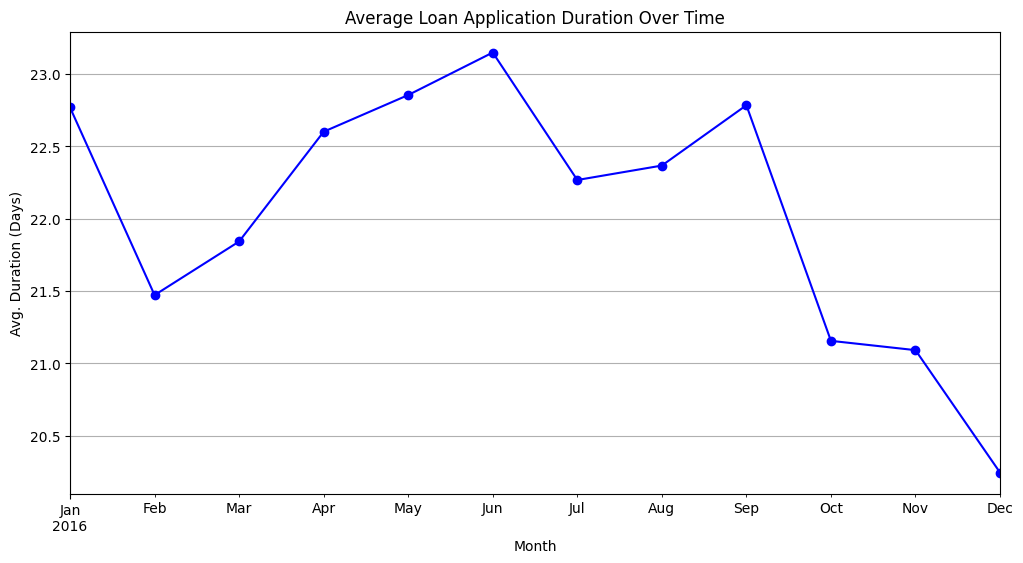

Temporal Analysis complete.


In [ ]:
# ===============================================
# ADVANCED ANALYSIS: TEMPORAL PERFORMANCE (Time Series)
# ===============================================
print("\n--- Advanced Analysis: Temporal Performance ---")

import matplotlib.pyplot as plt

# 1. Prepare the Data
case_stats = df_final.groupby('case:concept:name')['time:timestamp'].agg(['min', 'max'])
case_stats['duration_days'] = (case_stats['max'] - case_stats['min']).dt.total_seconds() / 86400
case_stats['start_month'] = case_stats['min'].dt.to_period('M')

# 2. Aggregate by Month
monthly_performance = case_stats.groupby('start_month')['duration_days'].mean()

# 3. Visualize
plt.figure(figsize=(12, 6))
monthly_performance.plot(kind='line', marker='o', color='b')

plt.title("Average Loan Application Duration Over Time")
plt.xlabel("Month")
plt.ylabel("Avg. Duration (Days)")
plt.grid(True)

plt.show()

print("Temporal Analysis complete.")
